In [ ]:
# Sentinel‑1 Flood Persistence (Days) — IF Flooded

# This notebook trains a model that predicts inundation duration (days) if a pixel were to flood.

# 1) Setup
import warnings
warnings.filterwarnings('ignore')
import sys
import subprocess
import logging

# Silence pip output
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'geemap==0.32.1', 'earthengine-api==0.1.408', '-q'])
!pip install geemap==0.32.1 earthengine-api==0.1.408

import ee, geemap
try:
    ee.Initialize(project='alvin360proxy1')
except Exception:
    ee.Authenticate()
    ee.Initialize(project='alvin360proxy1')
print('Earth Engine initialized.')

In [ ]:
# 2) AOIs from coordinates
def aoi_from_bounds(bounds):
    """bounds = [W, S, E, N] in lon/lat (EPSG:4326). Returns a FeatureCollection."""
    west, south, east, north = bounds
    geom = ee.Geometry.Rectangle([west, south, east, north], proj=None, geodesic=False)
    return ee.FeatureCollection(geom)

# AOIs for TRAINING (flood-affected areas)
BBOXES = {
    'Auckland':   [174.35, -37.20, 175.00, -36.70],
    'HawkesBay':  [176.45, -39.85, 177.20, -39.25],
    'Coromandel': [175.30, -37.25, 176.15, -36.40],
    'Auckland_CBD': [174.76, -36.855, 174.78, -36.845],
}
AOIS = {name: aoi_from_bounds(b) for name, b in BBOXES.items()}
print('AOIs available:', list(AOIS.keys()))

AOIs available: ['Auckland', 'HawkesBay', 'Coromandel', 'Auckland_CBD']


In [ ]:
# 3) Parameters
# EVENTS for TRAINING (use the flood-affected areas)
EVENTS = [
    {'name':'AKL_Anniv2023', 'aoi':'Auckland',   'start':'2023-01-25','end':'2023-02-10'},
    {'name':'Gabrielle_AKL', 'aoi':'Auckland',   'start':'2023-02-12','end':'2023-03-05'},
    {'name':'Gabrielle_HB',  'aoi':'HawkesBay',  'start':'2023-02-12','end':'2023-03-10'},
    {'name':'Gabrielle_CORO','aoi':'Coromandel', 'start':'2023-02-10','end':'2023-02-28'},
]

BASELINE = {'start':'2022-01-01','end':'2022-12-31'}

N_SAMPLES_PER_EVENT = 1000
RANDOM_SEED = 42
N_TREES = 50
MAX_NODES = 32
TILESCALE = 2

# Build optional EventAware model?
BUILD_EVENT_AWARE = True

# Permanent water threshold
PW_THRESH = 10

In [ ]:
# 4) Sentinel‑1 helpers & textures (EE‑Python safe)
def s1_sr(aoi_geom, start, end, orbit=None):
    col = (ee.ImageCollection('COPERNICUS/S1_GRD')
           .filterBounds(aoi_geom)
           .filterDate(start, end)
           .filter(ee.Filter.eq('instrumentMode', 'IW'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
           .filter(ee.Filter.eq('resolution_meters', 10)))
    if orbit:
        col = col.filter(ee.Filter.eq('orbitProperties_pass', orbit))
    col = col.map(lambda im: im.updateMask(im.select('VV').gt(-60)))

    dates = col.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format('YYYY-MM-dd'))
    # Compute and print average revisit interval in days
    def print_revisit(dates):
        import datetime
        dlist = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates.getInfo()]
        dlist.sort()
        if len(dlist) < 2:
            print("Not enough images to compute revisit interval.")
            return
        intervals = [(dlist[i+1] - dlist[i]).days for i in range(len(dlist)-1)]
        avg = sum(intervals) / len(intervals)
        print(f"Number of images: {len(dlist)} from {start}, {end}, {orbit}")
        print(f"Average revisit interval (days): {avg:.2f}")

    print_revisit(dates)

    return col

def add_ratio(img):
    return img.addBands(img.select('VV').subtract(img.select('VH')).rename('VV_VH_ratio'))

def add_ratio_div(img):
    # VV/VH ratio with small constant to avoid division by zero
    safe_vh = img.select('VH').add(ee.Number(0.001))
    return img.addBands(img.select('VV').divide(safe_vh).rename('VV_div_VH'))

def _std_neighborhood(img, band, radius_m=30):
    kernel = ee.Kernel.circle(radius_m, 'meters', normalize=False)
    return img.select([band]).reduceNeighborhood(ee.Reducer.stdDev(), kernel).rename(f'{band}_std')

def add_texture(img):
    vv_std = _std_neighborhood(img, 'VV', radius_m=30)
    vh_std = _std_neighborhood(img, 'VH', radius_m=30)
    return img.addBands([vv_std, vh_std])

In [ ]:
# 5) Baseline S1 stack (8 bands, unmasked)
def baseline_s1(aoi, baseline):
    aoi_geom = aoi.geometry()

    col = (
        s1_sr(aoi_geom, baseline['start'], baseline['end'])
        .map(add_ratio)       # VV − VH
        .map(add_ratio_div)   # VV / VH
        .map(add_texture)
    )

    red = col.reduce(
        ee.Reducer.median().combine(ee.Reducer.stdDev(), sharedInputs=True)
    )

    sel = [
        'VV_median', 'VH_median', 'VV_VH_ratio_median', 'VV_std_median', 'VH_std_median',
        'VV_stdDev', 'VH_stdDev', 'VV_VH_ratio_stdDev',
        'VV_div_VH_median', 'VV_div_VH_stdDev'
    ]

    red = red.select(sel).rename([
        'VV_med', 'VH_med', 'ratio_med', 'VV_std_med', 'VH_std_med',
        'VV_stddev', 'VH_stddev', 'ratio_stddev',
        'VV_div_VH_med', 'VV_div_VH_stddev'
    ])

    return red.unmask(0).clip(aoi_geom)

In [ ]:
# 6) DEM + static layers (DEM robust; all unmasked)
def _load_dem_image(aoi):
    aoi_geom = aoi.geometry()
    try:
        dem = ee.Image('NASA/NASADEM_HGT/001').select('elevation').rename('DEM')
    except Exception:
        try:
            dem = ee.Image('USGS/SRTMGL1_003').select('elevation').rename('DEM')
        except Exception:
            dem = ee.Image('JAXA/ALOS/AW3D30/V3_2').select('AVE_DSM').rename('DEM')
    return dem.clip(aoi_geom)

def dem_stack(aoi):
    aoi_geom = aoi.geometry()
    dem = _load_dem_image(aoi).rename('elev')
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    kernel = ee.Kernel.circle(1000, 'meters', normalize=False)
    local_min = dem.reduceNeighborhood(ee.Reducer.min(), kernel).unmask(dem)
    hand_like = dem.subtract(local_min).rename('hand_like')
    return dem.addBands([slope, aspect, hand_like]).unmask(0).clip(aoi_geom)

def landcover(aoi):
    aoi_geom = aoi.geometry()
    return ee.Image('ESA/WorldCover/v200/2021').select('Map').rename('lc').unmask(0).clip(aoi_geom)

def distance_to_water(aoi):
    aoi_geom = aoi.geometry()
    jrc = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence').gt(50)
    dist = jrc.fastDistanceTransform(30).sqrt().multiply(30).rename('dist_water')
    return dist.unmask(0).clip(aoi_geom)

def distance_to_coast(aoi):
    aoi_geom = aoi.geometry()
    ocean_like = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence').lte(1)
    dist = ocean_like.fastDistanceTransform(30).sqrt().multiply(30).rename('dist_coast')
    return dist.unmask(0).clip(aoi_geom)

def permanent_water_mask():
    lc = ee.Image('ESA/WorldCover/v200/2021').select('Map')
    land = lc.neq(80)  # Not equal to water class
    return land.rename('land_mask')

In [ ]:
# 7) Final feature stack (unmasked); mask only at the end
def static_baseline_features(aoi, baseline):
    return (baseline_s1(aoi, baseline)
            .addBands(dem_stack(aoi))
            .addBands(landcover(aoi))
            .addBands(distance_to_water(aoi))
            .addBands(distance_to_coast(aoi))
            .toFloat())

In [ ]:
# 8) Labels from S1 event time series (days flooded)
def event_stack(aoi, start, end):
    aoi_geom = aoi.geometry()
    asc = s1_sr(aoi_geom, start, end, 'ASCENDING')
    dsc = s1_sr(aoi_geom, start, end, 'DESCENDING')
    return asc.merge(dsc).sort('system:time_start')

def detect_flood_bak(img, base_med):
    dVV = base_med.select('VV_med').subtract(img.select('VV')).rename('dVV')
    dVH = base_med.select('VH_med').subtract(img.select('VH')).rename('dVH')
    flooded = dVV.gt(2.8).And(dVH.gt(2)).And(img.select('VV').lt(-10)).rename('flood_mask')
    return img.addBands([dVV, dVH, flooded])

def detect_flood(img, base_med):
    dVV = base_med.select('VV_med').subtract(img.select('VV')).rename('dVV')
    flooded = dVV.gt(2.8).And(img.select('VV').lt(-10)).rename('flood_mask')
    return img.addBands([dVV, flooded])

def detect_flood_1(img, base_img):
    """
    Flood detection using dynamic thresholds based on baseline statistics.
    Combines three conditions: low VV, low VH, and low VV/VH ratio.

    Parameters:
    - img: Sentinel-1 image to evaluate (must include VV and VH bands)
    - base_img: Baseline image with median and stdDev bands

    Returns:
    - Image with added bands: dVV, dVH, VV_div_VH, flood_mask
    """

    # Extract current VV and VH bands
    vv = img.select('VV')
    vh = img.select('VH')

    # Compute VV/VH ratio (add small constant to avoid division by zero)
    safe_vh = vh.add(ee.Number(0.001))
    ratio = vv.divide(safe_vh).rename('VV_div_VH')

    # Compute deviation from baseline median
    dVV = base_img.select('VV_med').subtract(vv).rename('dVV')
    dVH = base_img.select('VH_med').subtract(vh).rename('dVH')

    # Compute dynamic thresholds: mean + 3×stdDev
    TVV = base_img.select('VV_med').add(base_img.select('VV_stddev').multiply(3))
    TVH = base_img.select('VH_med').add(base_img.select('VH_stddev').multiply(3))
    TVVrVH = base_img.select('VV_div_VH_med').add(base_img.select('VV_div_VH_stddev').multiply(3))

    # Apply flood detection logic: any condition triggers flood
    flood_mask = (
        vv.lt(TVV)
        .Or(vh.lt(TVH))
        .Or(ratio.lt(TVVrVH))
    ).rename('flood_mask')

    # Return image with all relevant bands
    return img.addBands([dVV, dVH, ratio, flood_mask])

def persistence_days(aoi, start, end, base_img):
    stk = event_stack(aoi, start, end).map(lambda im: detect_flood(im, base_img))
    flood_count = stk.select('flood_mask').sum().rename('flood_count')

    revisit_days = 3

    days = flood_count.multiply(revisit_days).rename('days_flooded')
    return days

def event_delta_features(aoi, start, end, base_img):
    stk = event_stack(aoi, start, end).map(lambda im: detect_flood(im, base_img))
    dvv_max  = stk.select('dVV').max().rename('ev_dvv_max')
    dvv_mean = stk.select('dVV').mean().rename('ev_dvv_mean')
    vv_min   = stk.select('VV').min().rename('ev_vv_min')
    vv_mean  = stk.select('VV').mean().rename('ev_vv_mean')
    vh_min   = stk.select('VH').min().rename('ev_vh_min')
    vh_mean  = stk.select('VH').mean().rename('ev_vh_mean')
    fcount   = stk.select('flood_mask').sum().rename('ev_flood_count')
    return ee.Image.cat([dvv_max, dvv_mean, vv_min, vv_mean, vh_min, vh_mean, fcount]).toFloat().clip(aoi.geometry())

In [ ]:
# 9) Sample ALL land pixels (including non-flooded) for continuous prediction
def sample_all_land_pixels():
    """Sample from ALL land areas to ensure complete prediction coverage"""
    static_samples = []
    eventaware_samples = []

    for ev in EVENTS:
        aoi = AOIS[ev['aoi']]
        base = static_baseline_features(aoi, BASELINE)
        lab  = persistence_days(aoi, ev['start'], ev['end'], base)

        land = permanent_water_mask()

        # Sample RANDOMLY from ALL land areas (not conditional on flooding)
        static_img = base.addBands(lab.unmask(0)).updateMask(land)

        # Take MANY random samples from the entire land area
        samp = static_img.sample(
            region=aoi.geometry(),
            seed=RANDOM_SEED,
            numPixels=8000,
            scale=100,
            dropNulls=True,
            geometries=False,
            tileScale=2
        )
        static_samples.append(samp)

        if BUILD_EVENT_AWARE:
            evf = event_delta_features(aoi, ev['start'], ev['end'], base)
            e_img = base.addBands(evf).addBands(lab.unmask(0)).updateMask(land)
            samp_ev = e_img.sample(
                region=aoi.geometry(),
                seed=RANDOM_SEED+7,
                numPixels=8000,
                scale=100,
                dropNulls=True,
                geometries=False,
                tileScale=2
            )
            eventaware_samples.append(samp_ev)

    static_fc = ee.FeatureCollection(static_samples).flatten()
    event_fc = ee.FeatureCollection(eventaware_samples).flatten() if BUILD_EVENT_AWARE else None
    return static_fc, event_fc

print("Sampling ALL land pixels (including non-flooded) for continuous prediction...")
static_fc, eventaware_fc = sample_all_land_pixels()
print('StaticOnly samples:', static_fc.size().getInfo())
if eventaware_fc:
    print('EventAware samples:', eventaware_fc.size().getInfo())

Sampling ALL land pixels (including non-flooded) for continuous prediction...
Number of images: 176 from 2022-01-01, 2022-12-31, None
Average revisit interval (days): 2.06
Number of images: 4 from 2023-01-25, 2023-02-10, ASCENDING
Average revisit interval (days): 4.00
Number of images: 5 from 2023-01-25, 2023-02-10, DESCENDING
Average revisit interval (days): 3.00
Number of images: 4 from 2023-01-25, 2023-02-10, ASCENDING
Average revisit interval (days): 4.00
Number of images: 5 from 2023-01-25, 2023-02-10, DESCENDING
Average revisit interval (days): 3.00
Number of images: 176 from 2022-01-01, 2022-12-31, None
Average revisit interval (days): 2.06
Number of images: 8 from 2023-02-12, 2023-03-05, ASCENDING
Average revisit interval (days): 2.43
Number of images: 7 from 2023-02-12, 2023-03-05, DESCENDING
Average revisit interval (days): 2.83
Number of images: 8 from 2023-02-12, 2023-03-05, ASCENDING
Average revisit interval (days): 2.43
Number of images: 7 from 2023-02-12, 2023-03-05, DES

In [ ]:
print(static_fc.aggregate_histogram('days_flooded').getInfo())
print(eventaware_fc.aggregate_histogram('days_flooded').getInfo())


{'0': 14894, '12': 21, '15': 9, '18': 10, '21': 1, '3': 1441, '6': 730, '9': 49}
{'0': 15004, '12': 25, '15': 6, '18': 7, '3': 1484, '6': 732, '9': 40}


In [ ]:
# 10) Train models (regression in days)
STATIC_BANDS = [
    'VV_med','VH_med','ratio_med','VV_std_med','VH_std_med',
    'VV_stddev','VH_stddev','ratio_stddev', 'VV_div_VH_med', 'VV_div_VH_stddev',
    'elev','slope','aspect','hand_like','lc','dist_water','dist_coast'
]
EVENT_BANDS = ['ev_dvv_max','ev_dvv_mean','ev_vv_min','ev_vv_mean','ev_vh_min','ev_vh_mean','ev_flood_count']
TARGET = 'days_flooded'

def split(fc, seed=RANDOM_SEED, p=0.8):
    fc = fc.randomColumn('rand', seed=seed)
    return fc.filter(ee.Filter.lt('rand', p)), fc.filter(ee.Filter.gte('rand', p))

train_s, val_s = split(static_fc)
rf_static = (ee.Classifier.smileRandomForest(numberOfTrees=N_TREES, maxNodes=MAX_NODES)
             .setOutputMode('REGRESSION')
             .train(train_s, TARGET, STATIC_BANDS))

pred_s = val_s.classify(rf_static)
sqe_s = pred_s.aggregate_array('classification').zip(val_s.aggregate_array(TARGET))\
        .map(lambda z: ee.Number(ee.List(z).get(0)).subtract(ee.Number(ee.List(z).get(1))).pow(2))
rmse_s = ee.Number(sqe_s.reduce(ee.Reducer.mean())).sqrt()
print('StaticOnly validation RMSE (days):', rmse_s.getInfo())

if eventaware_fc:
    train_e, val_e = split(eventaware_fc, seed=RANDOM_SEED+1)
    rf_event = (ee.Classifier.smileRandomForest(numberOfTrees=N_TREES, maxNodes=MAX_NODES)
                .setOutputMode('REGRESSION')
                .train(train_e, TARGET, STATIC_BANDS + EVENT_BANDS))

    pred_e = val_e.classify(rf_event)
    sqe_e = pred_e.aggregate_array('classification').zip(val_e.aggregate_array(TARGET))\
            .map(lambda z: ee.Number(ee.List(z).get(0)).subtract(ee.Number(ee.List(z).get(1))).pow(2))
    rmse_e = ee.Number(sqe_e.reduce(ee.Reducer.mean())).sqrt()
    print('EventAware validation RMSE (days):', rmse_e.getInfo())
else:
    rf_event = None

StaticOnly validation RMSE (days): 1.3600494327975403
EventAware validation RMSE (days): 0.4916758741979681


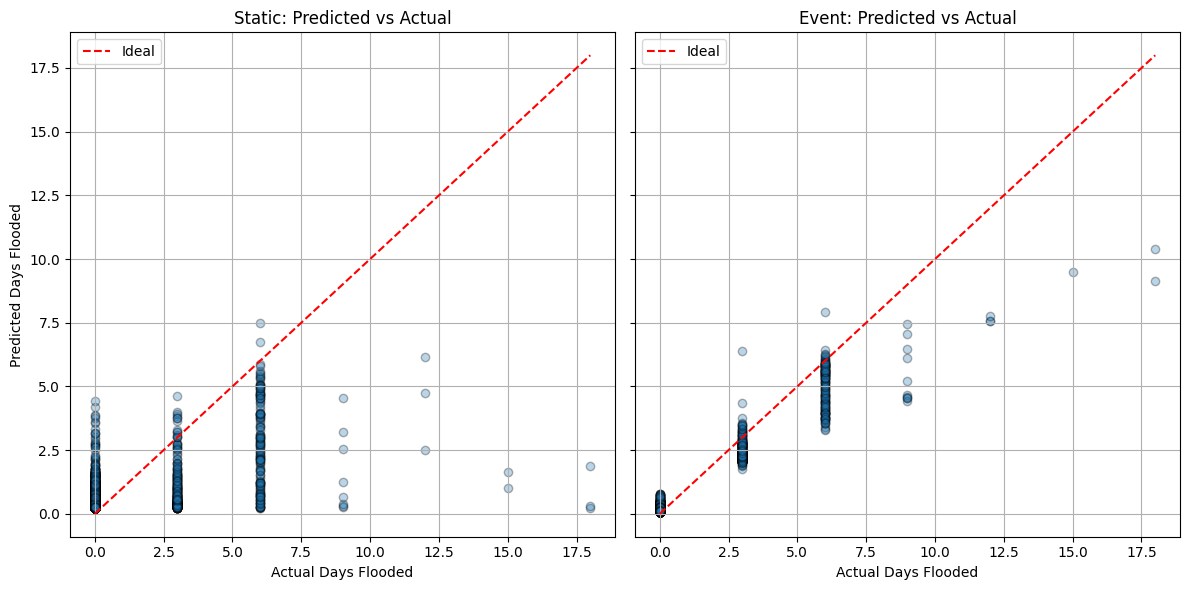

In [ ]:
import matplotlib.pyplot as plt

pred_static = pred_s.aggregate_array('classification').getInfo()
true_static = val_s.aggregate_array(TARGET).getInfo()

pred_event = pred_e.aggregate_array('classification').getInfo()
true_event = val_e.aggregate_array(TARGET).getInfo()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Static only
axes[0].scatter(true_static, pred_static, alpha=0.3, edgecolors='k')
axes[0].plot([0, max(true_static)], [0, max(true_static)], 'r--', label='Ideal')
axes[0].set_xlabel('Actual Days Flooded')
axes[0].set_ylabel('Predicted Days Flooded')
axes[0].set_title('Static: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# Event aware
axes[1].scatter(true_event, pred_event, alpha=0.3, edgecolors='k')
axes[1].plot([0, max(true_event)], [0, max(true_event)], 'r--', label='Ideal')
axes[1].set_xlabel('Actual Days Flooded')
axes[1].set_title('Event: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


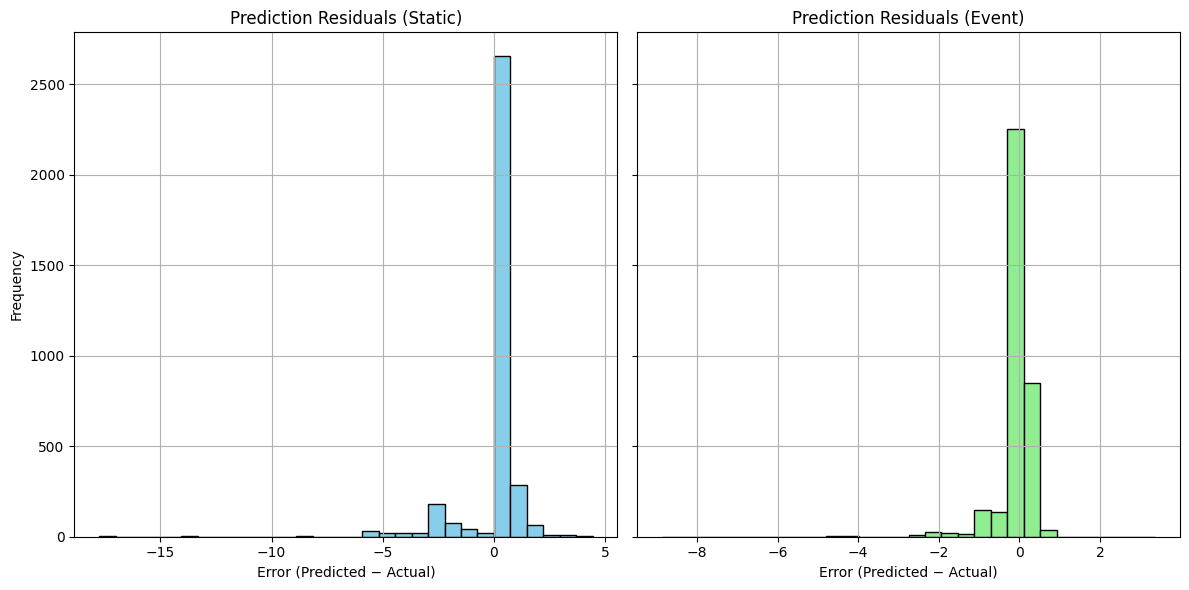

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

residuals_static = np.array(pred_static) - np.array(true_static)
residuals_event  = np.array(pred_event) - np.array(true_event)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# rf_static
axes[0].hist(residuals_static, bins=30, color='skyblue', edgecolor='k')
axes[0].set_title('Prediction Residuals (Static)')
axes[0].set_xlabel('Error (Predicted − Actual)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# rf_eventaware
axes[1].hist(residuals_event, bins=30, color='lightgreen', edgecolor='k')
axes[1].set_title('Prediction Residuals (Event)')
axes[1].set_xlabel('Error (Predicted − Actual)')
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# 11) Predict functions
def predict_duration_if_flood_baseline(aoi, water_thresh=PW_THRESH):
    """Predict flood duration for ALL land pixels (continuous heatmap)"""
    feats = static_baseline_features(aoi, BASELINE).select(STATIC_BANDS)
    pred  = feats.classify(rf_static).rename('pred_days_if_flood').max(0).min(30)
    land  = permanent_water_mask()
    pred  = pred.updateMask(land)
    vis = {'min':0, 'max':5,
           'palette':['#08306b','#2171b5','#6baed6','#c7e9b4','#fee08b','#fdae61','#f46d43','#d73027']}
    return pred.clip(aoi.geometry()), vis

def predict_duration_if_flood_during_event(aoi, start, end, water_thresh=PW_THRESH):
    """Predict flood duration for ALL land pixels during an event"""
    base = static_baseline_features(aoi, BASELINE).select(STATIC_BANDS)
    if 'rf_event' in globals() and rf_event is not None:
        ev = event_delta_features(aoi, start, end, base)
        feats = base.addBands(ev).select(STATIC_BANDS + EVENT_BANDS)
        model = rf_event
    else:
        feats = base
        model = rf_static
    pred  = feats.classify(model).rename('pred_days_if_flood').max(0).min(30)
    land  = permanent_water_mask()
    pred  = pred.updateMask(land)
    vis = {'min':0, 'max':5,
           'palette':['#08306b','#2171b5','#6baed6','#c7e9b4','#fee08b','#fdae61','#f46d43','#d73027']}
    return pred.clip(aoi.geometry()), vis

In [ ]:
# 12) Map preview - test on small CBD area
import ee
Map = geemap.Map(height=720)
name = 'Auckland_CBD'
# aoi = AOIS[name]
point = ee.Geometry.Point([174.7633, -36.8485])  # Auckland, NZ
aoi_auckland = point.buffer(10000).bounds()
aoi = ee.FeatureCollection(aoi_auckland)

pred_base, vis = predict_duration_if_flood_baseline(aoi)
# pred_aoi, vis = predict_duration_if_flood_during_event(aoi, EVENTS[1]['start'], EVENTS[1]['end'])

Map.centerObject(aoi, 13)
Map.addLayer(pred_base, vis, 'Flood Duration Prediction', opacity=0.9)
# Map.addLayer(pred_aoi, vis, 'Flood Duration Event', opacity=0.9)
Map.addLayer(aoi.style(color='red', fillColor='00000000', width=3), {}, 'AOI Boundary')
Map.add_layer_control()

Map.add_colorbar(vis, label='Predicted Flood Days')
Map

Number of images: 134 from 2022-01-01, 2022-12-31, None
Average revisit interval (days): 2.71


Map(center=[-36.848464820597734, 174.76346210269776], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# 13) Export example (Drive)
# Uncomment and modify as needed for export
# region = AOIS['Auckland'].geometry()
# img, _ = predict_duration_if_flood_baseline(AOIS['Auckland'], water_thresh=PW_THRESH)
# task = ee.batch.Export.image.toDrive(
#     image=img.toFloat(),
#     description=f'{name}_Duration_IF_Flood_StaticOnly_Continuous',
#     folder='EE_Exports',
#     fileNamePrefix=f'{name}_Duration_IF_Flood_StaticOnly_Continuous',
#     region=region,
#     scale=30,
#     maxPixels=1e13
# )
# task.start()
# print('Drive export started:', task.id)